In [34]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

Note: I added new features and fixed some old features, so older models might perform worse/better if running the same notebook.

In [36]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

In [37]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_AdjD,T2_AdjT,T2_Luck,T2_Strength of Schedule_AdjEM,T2_Strength of Schedule_OppO,T2_Strength of Schedule_OppD,T2_NCSOS_AdjEM,T1_seed,T2_seed,SeedDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,108.7,68.4,0.037,-12.96,94.4,107.4,-8.09,16,16,0
1,2003,134,1411,84,1421,92,0,1,29,67,...,113.5,68.0,0.119,-6.45,98.3,104.7,11.61,16,16,0
2,2003,136,1436,51,1112,80,0,0,20,64,...,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,16,1,15
3,2003,136,1112,80,1436,51,0,0,31,66,...,99.5,64.4,0.019,-5.14,99.3,104.4,-2.29,1,16,-15
4,2003,136,1113,84,1272,71,0,0,31,59,...,94.1,68.3,0.005,4.83,103.4,98.6,3.33,10,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,152,1403,61,1277,51,0,0,22,51,...,90.2,66.9,0.001,13.67,110.6,96.9,3.24,3,2,1
2226,2019,152,1120,62,1438,63,0,0,21,55,...,89.2,59.4,0.050,11.18,109.2,98.1,-3.24,5,1,4
2227,2019,152,1438,63,1120,62,0,0,25,51,...,95.9,67.9,0.008,12.23,110.7,98.5,2.63,1,5,-4
2228,2019,154,1438,85,1403,77,0,1,27,59,...,84.1,66.6,0.004,11.18,109.8,98.7,-5.39,1,3,-2


# Model Building

In [40]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [185]:
features = [
 'T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_FTMmean',
 'T1_FTAmean',
 'T1_ORmean',
 'T1_DRmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_Blkmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_FTMmean',
 'T1_opponent_FTAmean',
 'T1_opponent_ORmean',
 'T1_opponent_DRmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_opponent_PFmean',
 'T1_Ptsmean',
 'T1_opponent_Ptsmean',
 'Posmean',
 'T1_OffRtgmean',
 'T1_opponent_OffRtgmean',
 'T1_DefRtgmean',
 'T1_opponent_DefRtgmean',
 'T1_NetRtgmean',
 'T1_opponent_NetRtgmean',
 'T1_AstRmean',
 'T1_opponent_AstRmean',
 'T1_TORmean',
 'T1_opponent_TORmean',
 'T1_TSPmean',
 'T1_opponent_TSPmean',
 'T1_eFGPmean',
 'T1_opponent_eFGPmean',
 'T1_FTARmean',
 'T1_opponent_FTARmean',
 'T1_ORPmean',
 'T1_opponent_ORPmean',
 'T1_DRPmean',
 'T1_opponent_DRPmean',
 'T1_RPmean',
 'T1_opponent_RPmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_FTMmean',
 'T2_FTAmean',
 'T2_ORmean',
 'T2_DRmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_Blkmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_FTMmean',
 'T2_opponent_FTAmean',
 'T2_opponent_ORmean',
 'T2_opponent_DRmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_opponent_PFmean',
 'T2_Ptsmean',
 'T2_opponent_Ptsmean',
 'T2_Posmean',
 'T2_OffRtgmean',
 'T2_opponent_OffRtgmean',
 'T2_DefRtgmean',
 'T2_opponent_DefRtgmean',
 'T2_NetRtgmean',
 'T2_opponent_NetRtgmean',
 'T2_AstRmean',
 'T2_opponent_AstRmean',
 'T2_TORmean',
 'T2_opponent_TORmean',
 'T2_TSPmean',
 'T2_opponent_TSPmean',
 'T2_eFGPmean',
 'T2_opponent_eFGPmean',
 'T2_FTARmean',
 'T2_opponent_FTARmean',
 'T2_ORPmean',
 'T2_opponent_ORPmean',
 'T2_DRPmean',
 'T2_opponent_DRPmean',
 'T2_RPmean',
 'T2_opponent_RPmean',
 'T2_PointDiffmean',
 'T1_win_ratio_14d',
 'T2_win_ratio_14d',
#  'T1_Rk',
 'T1_AdjEM',
 'T1_AdjO',
 'T1_AdjD',
 'T1_AdjT',
 'T1_Luck',
 'T1_Strength of Schedule_AdjEM',
 'T1_Strength of Schedule_OppO',
 'T1_Strength of Schedule_OppD',
 'T1_NCSOS_AdjEM',
#  'T2_Rk',
 'T2_AdjEM',
 'T2_AdjO',
 'T2_AdjD',
 'T2_AdjT',
 'T2_Luck',
 'T2_Strength of Schedule_AdjEM',
 'T2_Strength of Schedule_OppO',
 'T2_Strength of Schedule_OppD',
 'T2_NCSOS_AdjEM',
 'T1_seed',
 'T2_seed',
#  'SeedDiff'
]

features_old = [
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
       'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
       'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
       'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
       'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
       'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
       'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 
    'T1_seed', 'T2_seed',
#        'SeedDiff'
]

features2 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 'T1_Rk',
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 'T2_Rk', 'T2_AdjEM',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 'T2_NCSOS_AdjEM', 'T1_seed', 'T2_seed',
   'SeedDiff'
]

In [141]:
features3 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 
   'T1_AdjT', 'T1_Luck',
   'T1_Strength of Schedule_AdjEM', 'T1_Strength of Schedule_OppO',
   'T1_Strength of Schedule_OppD', 'T1_NCSOS_AdjEM', 
    'T2_AdjT', 'T2_Luck',
   'T2_Strength of Schedule_AdjEM', 'T2_Strength of Schedule_OppO',
   'T2_Strength of Schedule_OppD', 
   'SeedDiff'
]

features4 = [
    'T1_win_ratio_14d', 'T2_win_ratio_14d', 
   'T1_AdjEM', 'T1_AdjO', 'T1_AdjD', 'T1_AdjT', 'T1_Luck',
   'T2_AdjO', 'T2_AdjD', 'T2_AdjT', 'T2_Luck',
]

features5 =  [
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d', 'T2_win_ratio_14d', 
]

In [149]:
features6 = [
 'T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_FTMmean',
 'T1_FTAmean',
 'T1_ORmean',
 'T1_DRmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_Blkmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_FTMmean',
 'T1_opponent_FTAmean',
 'T1_opponent_ORmean',
 'T1_opponent_DRmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_opponent_PFmean',
 'T1_Ptsmean',
 'T1_opponent_Ptsmean',
 'Posmean',
 'T1_OffRtgmean',
 'T1_opponent_OffRtgmean',
 'T1_DefRtgmean',
 'T1_opponent_DefRtgmean',
 'T1_NetRtgmean',
 'T1_opponent_NetRtgmean',
 'T1_AstRmean',
 'T1_opponent_AstRmean',
 'T1_TORmean',
 'T1_opponent_TORmean',
 'T1_TSPmean',
 'T1_opponent_TSPmean',
 'T1_eFGPmean',
 'T1_opponent_eFGPmean',
 'T1_FTARmean',
 'T1_opponent_FTARmean',
 'T1_ORPmean',
 'T1_opponent_ORPmean',
 'T1_DRPmean',
 'T1_opponent_DRPmean',
 'T1_RPmean',
 'T1_opponent_RPmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_FTMmean',
 'T2_FTAmean',
 'T2_ORmean',
 'T2_DRmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_Blkmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_FTMmean',
 'T2_opponent_FTAmean',
 'T2_opponent_ORmean',
 'T2_opponent_DRmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_opponent_PFmean',
 'T2_Ptsmean',
 'T2_opponent_Ptsmean',
 'T2_Posmean',
 'T2_OffRtgmean',
 'T2_opponent_OffRtgmean',
 'T2_DefRtgmean',
 'T2_opponent_DefRtgmean',
 'T2_NetRtgmean',
 'T2_opponent_NetRtgmean',
 'T2_AstRmean',
 'T2_opponent_AstRmean',
 'T2_TORmean',
 'T2_opponent_TORmean',
 'T2_TSPmean',
 'T2_opponent_TSPmean',
 'T2_eFGPmean',
 'T2_opponent_eFGPmean',
 'T2_FTARmean',
 'T2_opponent_FTARmean',
 'T2_ORPmean',
 'T2_opponent_ORPmean',
 'T2_DRPmean',
 'T2_opponent_DRPmean',
 'T2_RPmean',
 'T2_opponent_RPmean',
 'T2_PointDiffmean',
 'T1_win_ratio_14d',
 'T2_win_ratio_14d',
#  'T1_Rk',
#  'T1_AdjEM',
#  'T1_AdjO',
#  'T1_AdjD',
#  'T1_AdjT',
#  'T1_Luck',
#  'T1_Strength of Schedule_AdjEM',
#  'T1_Strength of Schedule_OppO',
#  'T1_Strength of Schedule_OppD',
#  'T1_NCSOS_AdjEM',
#  'T2_Rk',
#  'T2_AdjEM',
#  'T2_AdjO',
#  'T2_AdjD',
#  'T2_AdjT',
#  'T2_Luck',
#  'T2_Strength of Schedule_AdjEM',
#  'T2_Strength of Schedule_OppO',
#  'T2_Strength of Schedule_OppD',
#  'T2_NCSOS_AdjEM',
#  'T1_seed',
#  'T2_seed',
#  'SeedDiff'
]

In [142]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

# Model Building Pipeline

In [143]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import linear_model
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def reg_cv_train(features, 
                 estimator, 
                 mode='reg', 
                 plot=False, 
                 verbose=False,
                 test_df=None,
                 tourney_data=tourney_data
                ):
    preds_test=None
    # get full dataset:
    df = tourney_data.dropna(how='any').reset_index().copy()

    # split X and y:
    X = df[features]
    y = np.where(df['T1_PointDiff'] > 0, 1, 0)

    # use leave-one-group-out:
    logo = LeaveOneGroupOut()
    groups = df['Season']

    cvs = []
    
    season_ix = list(set(groups))
    season_ix.sort()

    for i , (train_ix, val_ix) in enumerate(logo.split(X, y, groups)):
        # split data:
        X_train = X.iloc[train_ix]
        y_train = y[train_ix]
        X_val = X.iloc[val_ix]
        y_val = y[val_ix]


        # fit pipeline:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('estimator', estimator)
        ])

        pipe.fit(X_train, y_train)

        # predict values:
        if mode == "reg":
            pred = pipe.predict(X_val)
            pred = np.clip(pred, 0, 1) # because regression
            if test_df is not None:
                preds_test = pipe.predict(test_df[features])
                preds_test = np.clip(preds_test, 0, 1)
        else:
            pred = pipe.predict_proba(X_val)[:, 1]
            if test_df is not None:
                preds_test = pipe.predict_proba(test_df[features])[:, 1]
        # plot:
        if plot:
            plt.figure(figsize=(15,6))
            plt.subplot(1,2,1)
            plt.scatter(pred, df.loc[val_ix, 'PointDiff'], s=5)
            plt.subplot(1,2,2)
            sns.histplot(pred)
            plt.show()

        # loss:
        loss = log_loss(y_val, pred)
        cvs.append(loss)

        if verbose: print(f"{season_ix[i]} Loss : {loss}")
    
    plt.figure()
    plt.plot(range(min(groups), min(groups) + len(set(groups))), cvs)
    plt.xlabel("Year")
    plt.ylabel("Log Loss")

    print(f"Local CV Loss : {np.mean(cvs):.3f}  -----  {estimator.__class__.__name__}")
    return np.mean(cvs), preds_test

# Linear Regression

2003 Loss : 0.4350885304765265
2004 Loss : 0.4300668558931367
2005 Loss : 0.3338388442098802
2006 Loss : 0.393027187266614
2007 Loss : 0.40893253060048096
2008 Loss : 0.33811944603811767
2009 Loss : 0.3673864312547892
2010 Loss : 0.42792996510955705
2011 Loss : 0.6281096994363727
2012 Loss : 0.4293976995056572
2013 Loss : 0.3764832711080753
2014 Loss : 0.3920165489313129
2015 Loss : 0.4686422575460729
2016 Loss : 0.44684361281463647
2017 Loss : 0.369731951630292
2018 Loss : 0.4285168066093079
2019 Loss : 0.2833423883888587
Local CV Loss : 0.409  -----  LogisticRegression
Wall time: 1.1 s


(0.40926317804821694, None)

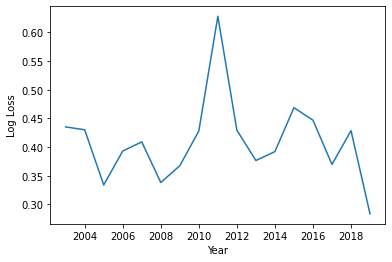

In [168]:
%%time
from sklearn.linear_model import LinearRegression, LogisticRegression

# basic model:
model = LogisticRegression(max_iter=200)

reg_cv_train(
        features=features_old, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True)

2003 Loss : 0.4602955954516573
2004 Loss : 0.44750527192040035
2005 Loss : 0.3436491626949934
2006 Loss : 0.3936364677087969
2007 Loss : 0.4104697021194559
2008 Loss : 0.33991326768943037
2009 Loss : 0.37750076963950985
2010 Loss : 0.4273587598324342
2011 Loss : 0.6382940957825203
2012 Loss : 0.4561185930131867
2013 Loss : 0.37125902264758365
2014 Loss : 0.3855873731604573
2015 Loss : 0.4784029292355226
2016 Loss : 0.46084658890413
2017 Loss : 0.3882844351581687
2018 Loss : 0.4222729716149751
2019 Loss : 0.28244376392691395
Local CV Loss : 0.417  -----  LogisticRegression


(0.41669639826471394, None)

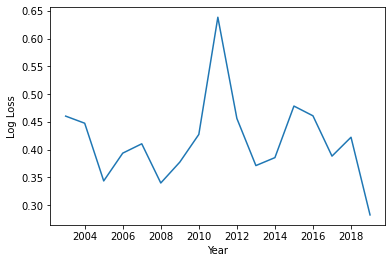

In [186]:
reg_cv_train(
        features=features, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True)

# Recursive Feature Selection

In [215]:
%%time
from sklearn.feature_selection import RFE

model = LinearRegression()

# get full dataset:
df = tourney_data.dropna(how='any').reset_index().copy()

# split X and y:
X = df[features]
y = np.where(df['T1_PointDiff'] > 0, 1, 0)

selector = RFE(model, step=1, n_features_to_select=20)
selector.fit(X, y)

Wall time: 1.7 s


RFE(estimator=LinearRegression(), n_features_to_select=20)

2003 Loss : 0.6175196506162786
2004 Loss : 0.6092163809201505
2005 Loss : 0.5315875840199438
2006 Loss : 0.5757325322063346
2007 Loss : 0.5278237396848988
2008 Loss : 0.49028728269404104
2009 Loss : 0.5731166289201541
2010 Loss : 0.6247492529343203
2011 Loss : 0.6693254603583209
2012 Loss : 0.62666226315711
2013 Loss : 0.6125361185445398
2014 Loss : 0.6117768247048574
2015 Loss : 0.5544331373393646
2016 Loss : 0.5984219371086392
2017 Loss : 0.6170062801442766
2018 Loss : 0.6547614018523404
2019 Loss : 0.5709606030429409
Local CV Loss : 0.592  -----  LogisticRegression


(0.5921127693087359, None)

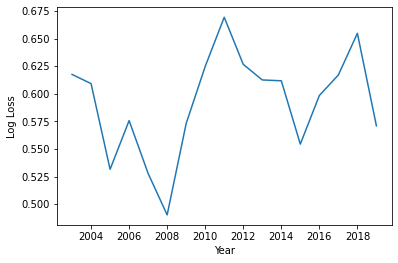

In [216]:
%%time
from sklearn.feature_selection import RFE

model = LinearRegression()

# get full dataset:
df = tourney_data.dropna(how='any').reset_index().copy()

# split X and y:
X = df[features]
y = np.where(df['T1_PointDiff'] > 0, 1, 0)

selector = RFE(model, step=1, n_features_to_select=20)
selector.fit(X, y)

from itertools import compress
features7 = list(compress(features, selector.support_))

model = LogisticRegression(max_iter=300)

reg_cv_train(
        features=features7, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True)

In [217]:
features7

['T1_opponent_FGMmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FTMmean',
 'T1_Ptsmean',
 'T1_OffRtgmean',
 'T1_opponent_DefRtgmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGM3mean',
 'T2_FTMmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FTMmean',
 'T2_Ptsmean',
 'T2_opponent_Ptsmean',
 'T2_DefRtgmean',
 'T2_opponent_DefRtgmean',
 'T2_NetRtgmean',
 'T2_opponent_NetRtgmean',
 'T2_PointDiffmean']

# Remove Anomoly Years

2003 Loss : 0.4458097920495807
2004 Loss : 0.4251560600635781
2005 Loss : 0.3198334022172856
2006 Loss : 0.39810596177345303
2007 Loss : 0.4045473498196035
2008 Loss : 0.33268281162712143
2009 Loss : 0.37019535028464323
2010 Loss : 0.4435617078308768
2012 Loss : 0.43020614317613065
2013 Loss : 0.3721772306018575
2014 Loss : 0.3896675062438671
2015 Loss : 0.4699781499747926
2016 Loss : 0.45794278557145707
2017 Loss : 0.3624040644383076
2018 Loss : 0.43226165625450214
2019 Loss : 0.2772095010363572
Local CV Loss : 0.396  -----  LogisticRegression


(0.3957337170602134, None)

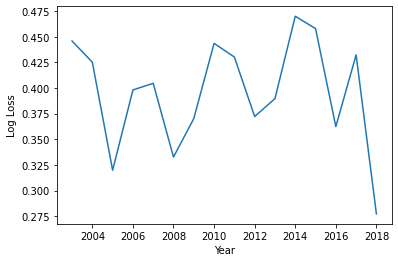

In [139]:
remove_years = [2011]
df2 = tourney_data.copy()
df2 = df2[~df2['Season'].isin(remove_years)]

reg_cv_train(
        features=features_old, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=True,
    tourney_data=df2
)

# Hyper Parameter Tuning

In [57]:
#feature set choice:
scores = []
params = dict(random_state = 1)
model = RandomForestClassifier(**params)

for f in [features, features_old, features2, features3, features4, features5]:
    scores.append(
        reg_cv_train(
        features=f, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=False)
    )
    
scores

KeyboardInterrupt: 

In [ ]:
# basic model:
model = RandomForestClassifier()

reg_cv_train(
        features=features, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=False)

n_estimators = [5, 10, 50, 100, 150, 200]
params = dict(
    random_state = 1
)

scores = []
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, **params)
    scores.append(reg_cv_train(
        features=features, 
        estimator=model,
        mode='cls', 
        plot=False, 
        verbose=False)
                 )

# Test Set

In [15]:
from src.features import build_features

test_data = pd.read_csv("../data/external/MSampleSubmissionStage1.csv")
test_data[['Season', 'T1_TeamID', 'T2_TeamID']] = test_data['ID'].str.split("_",expand=True)
for c in ['Season', 'T1_TeamID', 'T2_TeamID']:
    test_data[c] = test_data[c].astype(int)
    
test_data = build_features.build_test_data(test_data)

Local CV Loss : 0.500  -----  LogisticRegression


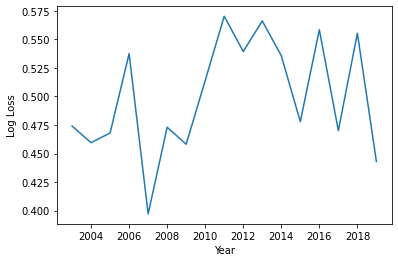

In [16]:
cv_score, test_preds = reg_cv_train(
        features=features4, 
        estimator=linear_model.LogisticRegression(),
        mode='cls', 
        plot=False, 
        verbose=False,
        test_df=test_data
)

<AxesSubplot:ylabel='Count'>

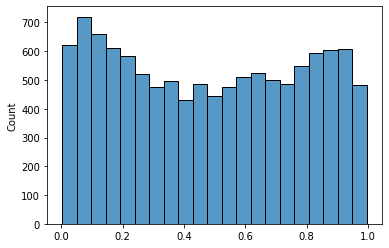

In [17]:
sns.histplot(test_preds)